In [15]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")

import random
import math
import numpy as np
import torch as t
import torch.utils.data as tdata
import matplotlib.pyplot as plt
from einops import rearrange

from dots.training import *
from dots.models import MLP, DeepLinear
from dots.dots import *
from dots.utils import get_device, entropy, plot_dots_stats, random_batch, range_batch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
device = get_device()
print(device)

cpu


In [7]:
def dlmrank(sizes, N=1000):
    dlm = DeepLinear(sizes[0], sizes[-1], hidden=sizes[1:-1], bias=False)
    return dlm.jacobian_matrix_rank(
        range_batch(-t.ones(sizes[0]), t.ones(sizes[0]), n=N)
    )

In [8]:
dlmrank([2, 1, 2])

/home/lrudl/miniconda3/envs/dots_env/lib/python3.10/site-packages/torch/nn/utils/stateless.py:216: UserWarning: This API is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use torch.func.functional_call instead which is a drop-in replacement for this API.
  warnings.warn(


tensor(3)

In [10]:
dlmrank([2, 1, 2], N=2)

tensor(3)

In [12]:
dlmrank([4, 2, 5], N=1)

/home/lrudl/miniconda3/envs/dots_env/lib/python3.10/site-packages/torch/nn/utils/stateless.py:216: UserWarning: This API is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use torch.func.functional_call instead which is a drop-in replacement for this API.
  warnings.warn(


tensor(5)

In [11]:
dlmrank([4, 2, 5], N=1000)

/home/lrudl/miniconda3/envs/dots_env/lib/python3.10/site-packages/torch/nn/utils/stateless.py:216: UserWarning: This API is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use torch.func.functional_call instead which is a drop-in replacement for this API.
  warnings.warn(


tensor(14)

In [23]:
dlmrank([4, 1, 2, 1, 2, 1, 4], N=1000)

tensor(7)

In [24]:
dlmrank([5, 4, 3, 2, 3, 4, 3, 2, 3, 4, 3, 2, 5])

/home/lrudl/miniconda3/envs/dots_env/lib/python3.10/site-packages/torch/nn/utils/stateless.py:216: UserWarning: This API is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use torch.func.functional_call instead which is a drop-in replacement for this API.
  warnings.warn(


tensor(16)

In [13]:
dlmrank([4, 5, 4])

/home/lrudl/miniconda3/envs/dots_env/lib/python3.10/site-packages/torch/nn/utils/stateless.py:216: UserWarning: This API is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use torch.func.functional_call instead which is a drop-in replacement for this API.
  warnings.warn(


tensor(16)

In [19]:
def formula(sizes):
    d, b, m = sizes
    return min(m * b + max(0, d - b) * b, m * d)

In [20]:
for _ in range(40):
    sizes = [random.randint(1, 8) for _ in range(3)]
    predicted = formula(sizes)
    actual = dlmrank(sizes)
    print(predicted == actual, sizes, predicted, actual)

/home/lrudl/miniconda3/envs/dots_env/lib/python3.10/site-packages/torch/nn/utils/stateless.py:216: UserWarning: This API is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use torch.func.functional_call instead which is a drop-in replacement for this API.
  warnings.warn(


tensor(True) [3, 7, 2] 6 tensor(6)
tensor(True) [7, 6, 6] 42 tensor(42)
tensor(True) [3, 5, 2] 6 tensor(6)
tensor(True) [4, 3, 6] 21 tensor(21)
tensor(True) [1, 7, 5] 5 tensor(5)
tensor(True) [5, 8, 3] 15 tensor(15)
tensor(True) [5, 3, 8] 30 tensor(30)
tensor(True) [4, 5, 5] 20 tensor(20)
tensor(True) [5, 6, 3] 15 tensor(15)
tensor(True) [4, 5, 2] 8 tensor(8)
tensor(True) [7, 5, 3] 21 tensor(21)
tensor(True) [4, 7, 8] 32 tensor(32)
tensor(True) [3, 2, 4] 10 tensor(10)
tensor(True) [6, 7, 5] 30 tensor(30)
tensor(True) [7, 7, 6] 42 tensor(42)
tensor(True) [1, 6, 2] 2 tensor(2)
tensor(True) [2, 7, 2] 4 tensor(4)
tensor(True) [7, 6, 8] 54 tensor(54)
tensor(True) [2, 6, 7] 14 tensor(14)
tensor(True) [2, 1, 3] 4 tensor(4)
tensor(True) [2, 4, 6] 12 tensor(12)
tensor(True) [7, 4, 6] 36 tensor(36)
tensor(True) [5, 7, 8] 40 tensor(40)
tensor(True) [7, 4, 7] 40 tensor(40)
tensor(True) [8, 6, 5] 40 tensor(40)
tensor(True) [5, 1, 8] 12 tensor(12)
tensor(True) [3, 5, 5] 15 tensor(15)
tensor(True) [5

In [16]:
random.randint(1, 5)

3

# Deep linear models


In [3]:
deep_linear = DeepLinear(1, 1, hidden=5, hidden_size=10, bias=False).to(device)
deep_linear.count_params()

420

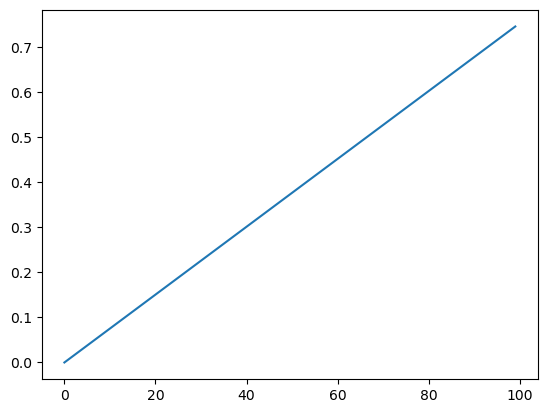

In [5]:
plt.plot(
    deep_linear(
        t.linspace(0, 5, 100).unsqueeze(-1).to(device)
    ).detach().cpu().numpy()
)

In [6]:
deep_linear.matrix_jacobian(random_batch(10, 1)).shape

torch.Size([10, 420])

Jacobian rank ranks: [tensor(1), tensor(1), tensor(1)]
SV rank, entropy ranks: [tensor(1.0000), tensor(1.0000), tensor(1.0000)]
SV rank, heuristic threshold ranks: [1, 1, 1]
Maximum rank ranks: [10, 100, 420]
Parameters in model: 420


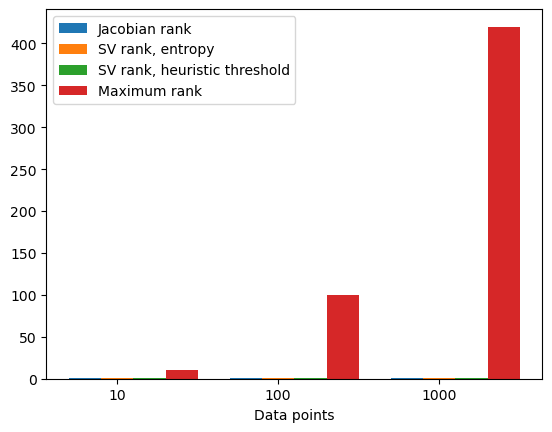

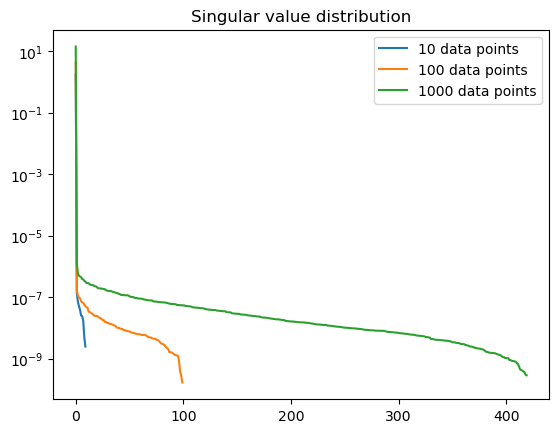

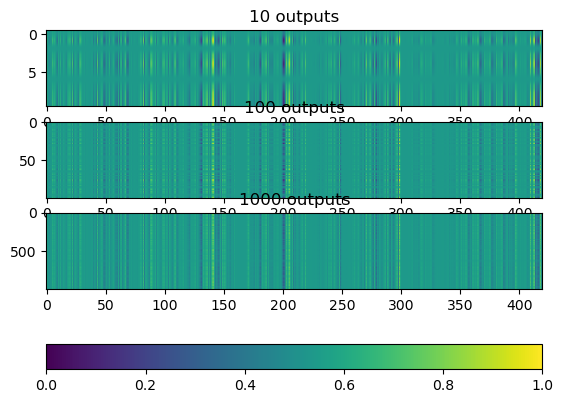

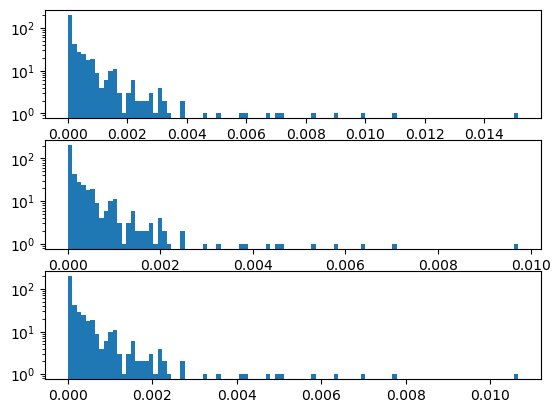

In [7]:
plot_dots_stats(
    deep_linear,
    [
        random_batch(10, 1),
        random_batch(100, 1),
        random_batch(1000, 1)
    ]
)

Jacobian rank ranks: [tensor(5), tensor(5), tensor(5)]
SV rank, entropy ranks: [tensor(1.5834), tensor(1.7367), tensor(1.7206)]
SV rank, heuristic threshold ranks: [1, 1, 1]
Maximum rank ranks: [40, 400, 501]
Parameters in model: 501


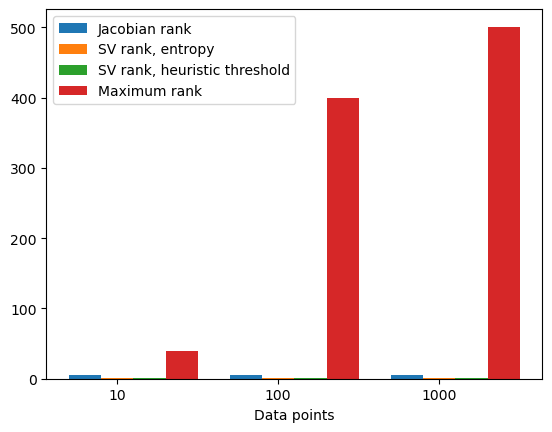

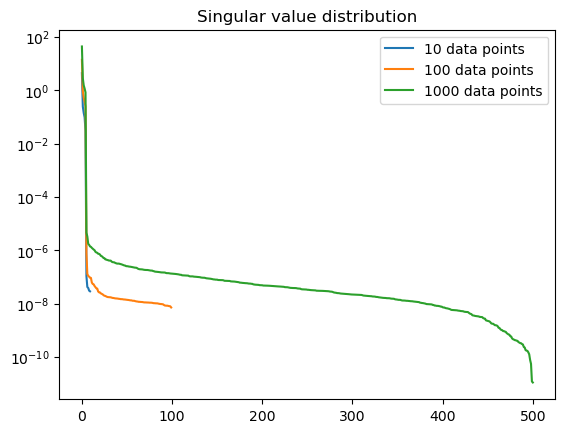

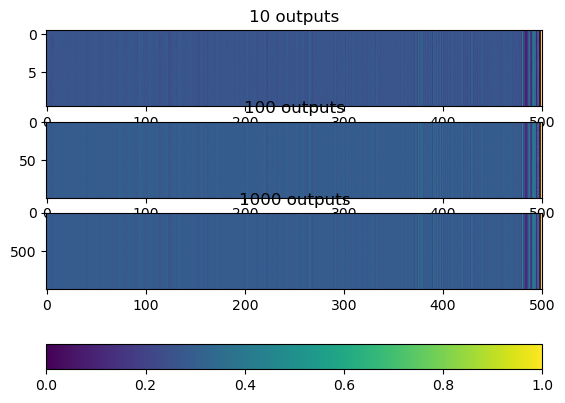

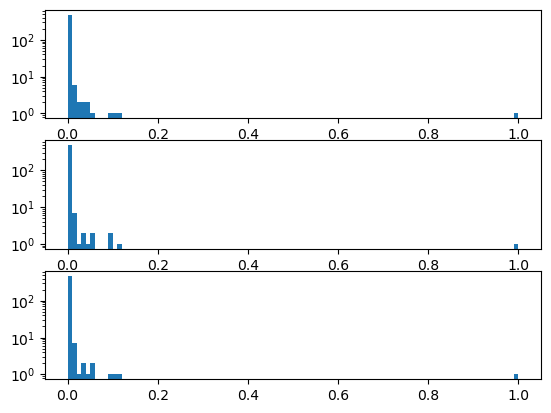

In [8]:
deep_linear2 = DeepLinear(4, 1, hidden=5, hidden_size=10).to(device)

plot_dots_stats(
    deep_linear2,
    [
        random_batch(10, 4),
        random_batch(100, 4),
        random_batch(1000, 4)
    ]
)

Jacobian rank ranks: [tensor(6), tensor(6), tensor(6)]
SV rank, entropy ranks: [tensor(2.9880), tensor(3.1395), tensor(3.1301)]
SV rank, heuristic threshold ranks: [2, 2, 2]
Maximum rank ranks: [20, 200, 492]
Parameters in model: 492


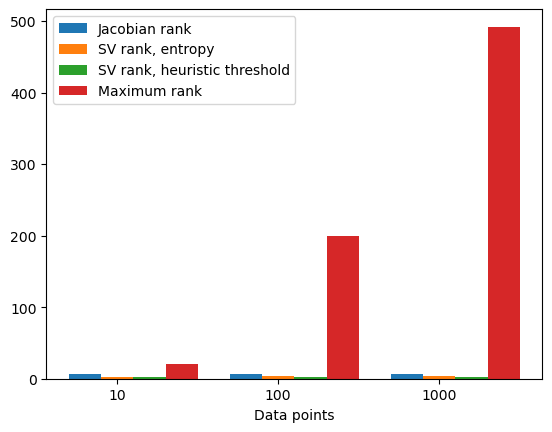

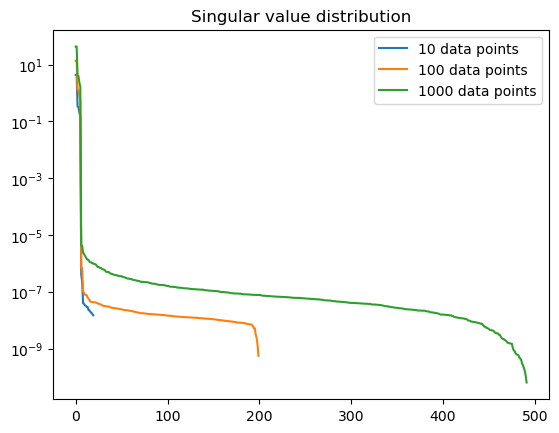

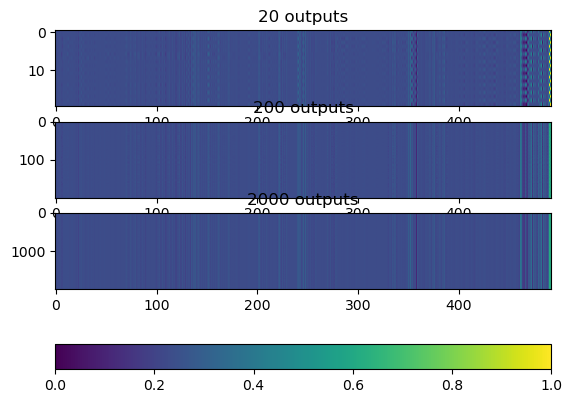

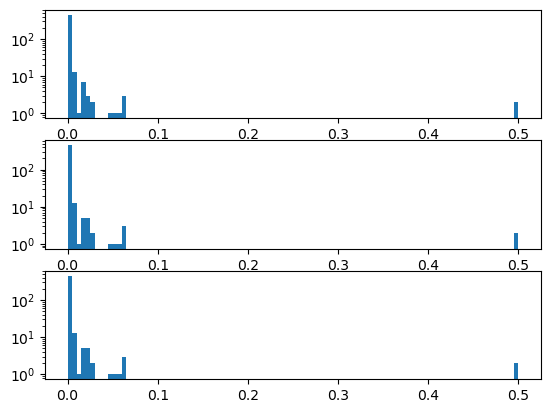

In [9]:
deep_linear3 = DeepLinear(2, 2, hidden=5, hidden_size=10).to(device)

plot_dots_stats(
    deep_linear3,
    [
        random_batch(10, 2),
        random_batch(100, 2),
        random_batch(1000, 2)
    ]
)